<a href="https://colab.research.google.com/github/trnq-eu/learnpytorch/blob/main/02_pytorch_nn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Neural Network Classification


## 1. Make classification data and get it ready
We'll use the make_circles() method from Scikit-Learn to generate two circles with different coloured dots.

In [1]:
from sklearn.datasets import make_circles
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html

# Make 1000 samples
n_samples = 1000

# Creates circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# conteggio dei valori univoci delle etichette
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

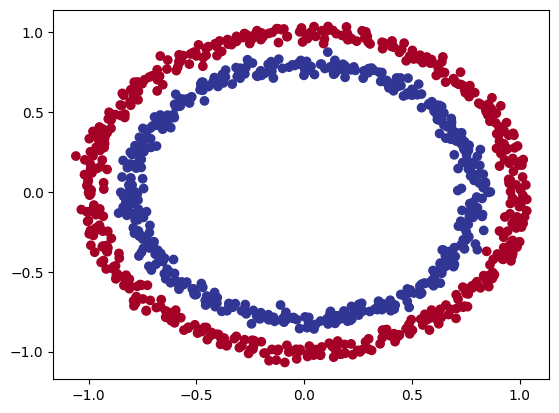

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape


((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [8]:
import torch

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# per splittare i dati in train e test usiamo train_test_split di scikit_learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state= 42 # make it reproducible
                                                    )

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model

In [10]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Let's create a model class that:

Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
Defines a forward() method containing the forward pass computation of the model.
Instantiates the model class and sends it to the target device.

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3. Define a forward method containing the forward pass computation
  def forward(self, x):
    # Return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test).to(device)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3613],
        [-0.4153],
        [-0.0968],
        [-0.4367],
        [ 0.0982],
        [ 0.0637],
        [-0.2429],
        [-0.1303],
        [-0.1054],
        [-0.4167]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
from torch.nn.modules.loss import BCEWithLogitsLoss
# create a binary cross entropy loss function

loss_fn = BCEWithLogitsLoss() # contiene una funzione sigmoide all'interno

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

In [10]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model

Before we the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.

In [16]:
# Forward pass
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3613],
        [-0.4153],
        [-0.0968],
        [-0.4367],
        [ 0.0982]], grad_fn=<SliceBackward0>)

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4107],
        [0.3977],
        [0.4758],
        [0.3925],
        [0.5245]], grad_fn=<SigmoidBackward0>)

The values are now in the form of prediction probabilities

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 1.], grad_fn=<SqueezeBackward0>)

### Build a training and testing loop

In [19]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70128, Accuracy: 46.50% | Test loss: 0.69481, Test acc: 51.00%
Epoch: 10 | Loss: 0.69837, Accuracy: 48.00% | Test loss: 0.69255, Test acc: 49.00%
Epoch: 20 | Loss: 0.69688, Accuracy: 48.25% | Test loss: 0.69170, Test acc: 52.00%
Epoch: 30 | Loss: 0.69595, Accuracy: 48.88% | Test loss: 0.69137, Test acc: 52.50%
Epoch: 40 | Loss: 0.69530, Accuracy: 48.88% | Test loss: 0.69128, Test acc: 51.00%
Epoch: 50 | Loss: 0.69482, Accuracy: 48.62% | Test loss: 0.69131, Test acc: 52.00%
Epoch: 60 | Loss: 0.69446, Accuracy: 48.38% | Test loss: 0.69141, Test acc: 52.50%
Epoch: 70 | Loss: 0.69418, Accuracy: 48.75% | Test loss: 0.69154, Test acc: 54.00%
Epoch: 80 | Loss: 0.69397, Accuracy: 48.50% | Test loss: 0.69169, Test acc: 53.50%
Epoch: 90 | Loss: 0.69380, Accuracy: 49.00% | Test loss: 0.69185, Test acc: 53.00%


In [15]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

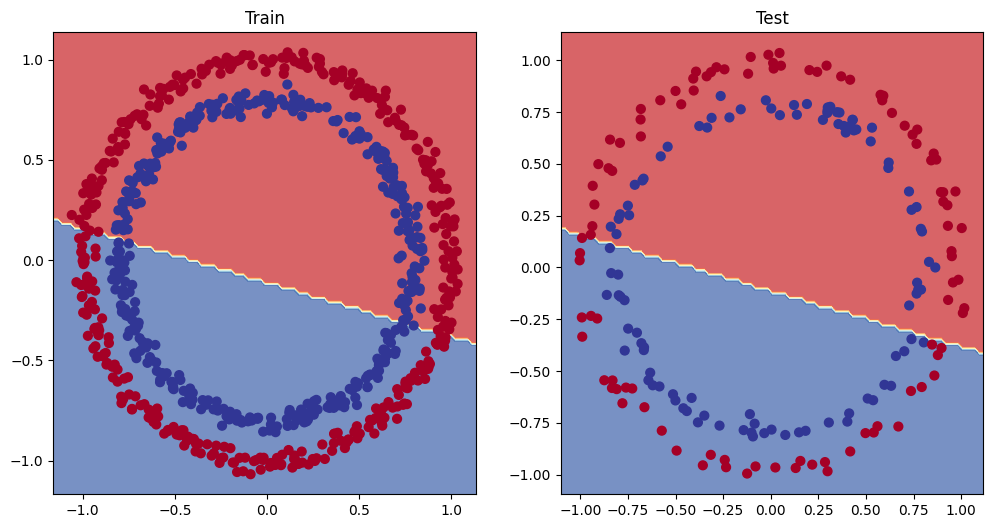

In [21]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.

We'll follow the same steps we did above but with a few changed hyperparameters.

In [22]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [24]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training

  # 1. forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. loss - accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. optimizer zero_grad
  optimizer.zero_grad()

  # 4. backprop
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    # 1. forward pass
    # create test logits
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate loss - accurcy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f'Epoch:{epoch}, Loss: {loss:.5f}, Accuracy: {acc:.2f}, Test loss:{test_loss:.5f}.5f, Test accuracy: {test_acc}')





Epoch:0, Loss: 0.69396, Accuracy: 50.88, Test loss:0.69261.5f, Test accuracy: 51.0
Epoch:100, Loss: 0.69305, Accuracy: 50.38, Test loss:0.69379.5f, Test accuracy: 48.0
Epoch:200, Loss: 0.69299, Accuracy: 51.12, Test loss:0.69437.5f, Test accuracy: 46.0
Epoch:300, Loss: 0.69298, Accuracy: 51.62, Test loss:0.69458.5f, Test accuracy: 45.0
Epoch:400, Loss: 0.69298, Accuracy: 51.12, Test loss:0.69465.5f, Test accuracy: 46.0
Epoch:500, Loss: 0.69298, Accuracy: 51.00, Test loss:0.69467.5f, Test accuracy: 46.0
Epoch:600, Loss: 0.69298, Accuracy: 51.00, Test loss:0.69468.5f, Test accuracy: 46.0
Epoch:700, Loss: 0.69298, Accuracy: 51.00, Test loss:0.69468.5f, Test accuracy: 46.0
Epoch:800, Loss: 0.69298, Accuracy: 51.00, Test loss:0.69468.5f, Test accuracy: 46.0
Epoch:900, Loss: 0.69298, Accuracy: 51.00, Test loss:0.69468.5f, Test accuracy: 46.0


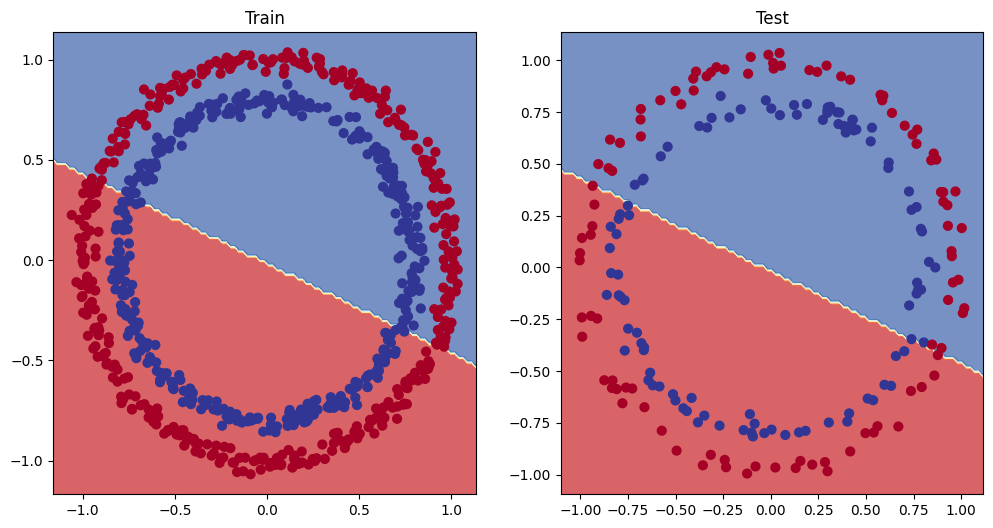

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [26]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = X_regression * weight + bias

print(len(X_regression))

X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [27]:
# create test and train split
train_split = int(len(X_regression) * 0.8)
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the length

print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression))

80 80 20 20


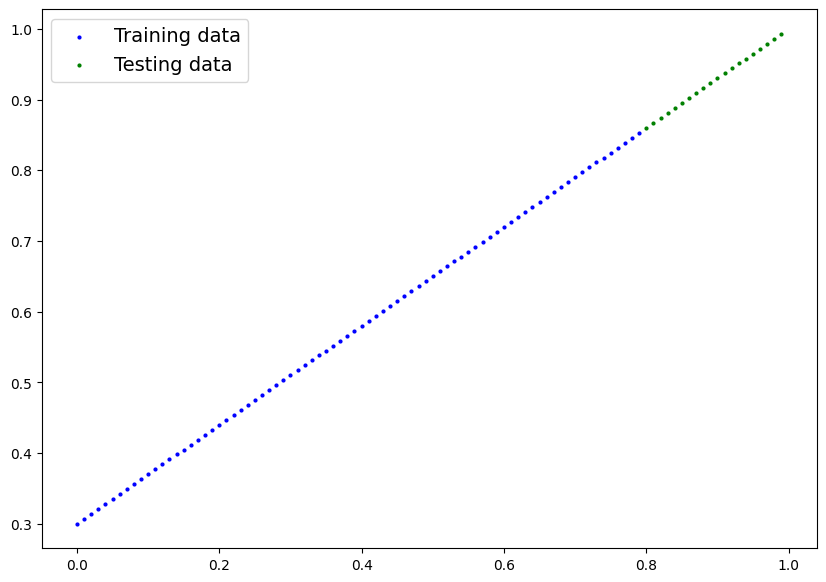

In [28]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

Now we've got some data, let's recreate model_1 but with a loss function suited to our regression data.

In [29]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)

In [31]:
torch.manual_seed(42)

epochs = 1000

# Put data to target device

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ### Training
  # 1. forward pass
  y_pred = model_2(X_train_regression)

  # 2. calculate loss
  loss = loss_fn(y_pred, y_train_regression)

  # 3. optim zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optim step
  optimizer.step()

  ### Testing
  model_2.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")



Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360


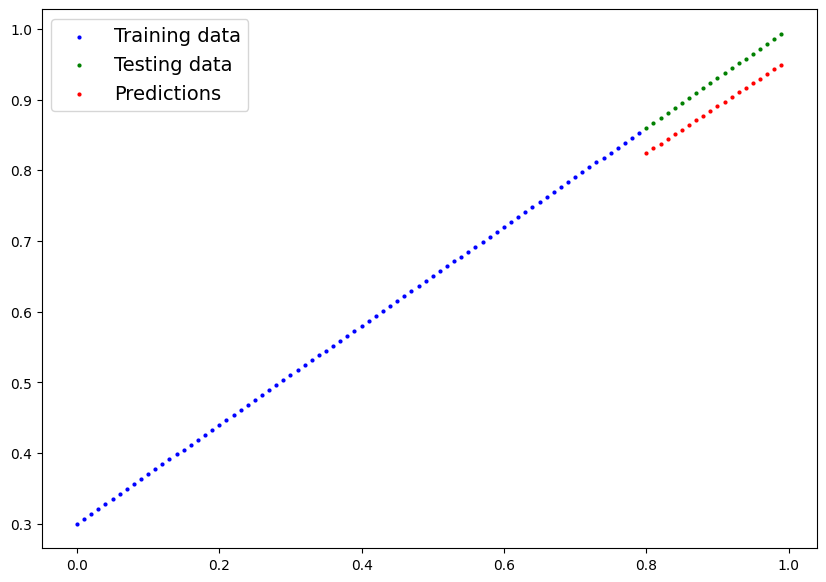

In [32]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## The missing piece: non-linearity

Recreating data



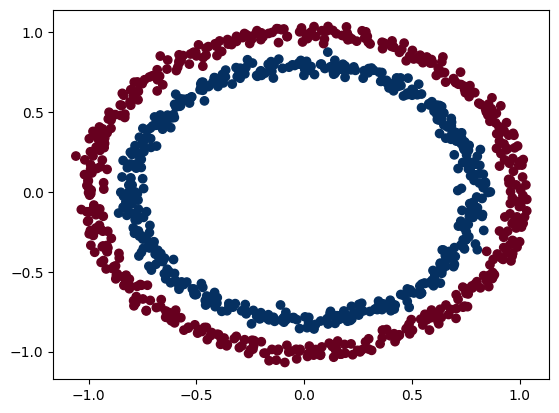

In [33]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [34]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [35]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=10)
    self.relu = nn.ReLU() # <- add in ReLU activation function

  def forward(self, x):
    # Intersperse the ReLU activation function between layers
     return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)




CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (relu): ReLU()
)


In [36]:
# set-up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [37]:
torch.manual_seed(42)
epochs=1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Loss - Accuracy
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
  acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

  # 3. Optimizer zero_grad
  optimizer.zero_grad()

  # 4. Backprop
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Loss - accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)


# Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")



ValueError: ignored

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Model 1")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Model 3")
plot_decision_boundary(model_3, X_train, y_train) # model_3 = has non-linearity

## Replicating a non-linear activation function

In [38]:
# toy dataset
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

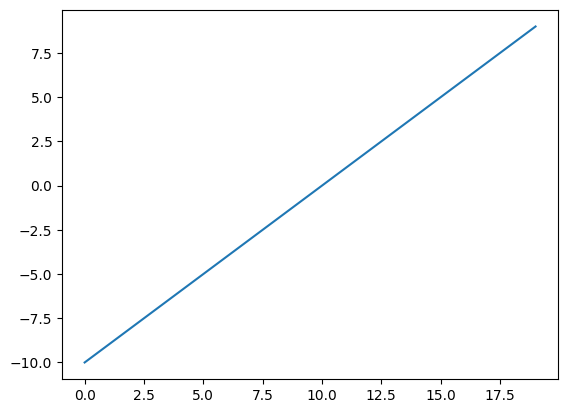

In [39]:
plt.plot(A)

Instead of using PyTorch's ReLU (torch.nn.ReLU), we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [40]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

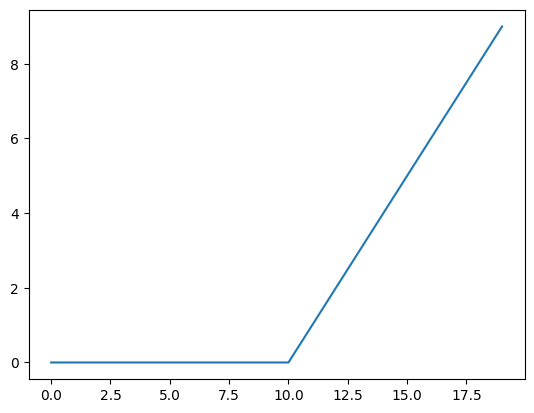

In [41]:
plt.plot(relu(A))

Let's build a function to replicate the sigmoid function with PyTorch.



In [ ]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

In [ ]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A))

## Create a multiclass classification model

1. Create some multi-class data with make_blobs().
2. Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
3. Split the data into training and test sets using train_test_split().
4. Visualize the data.



tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


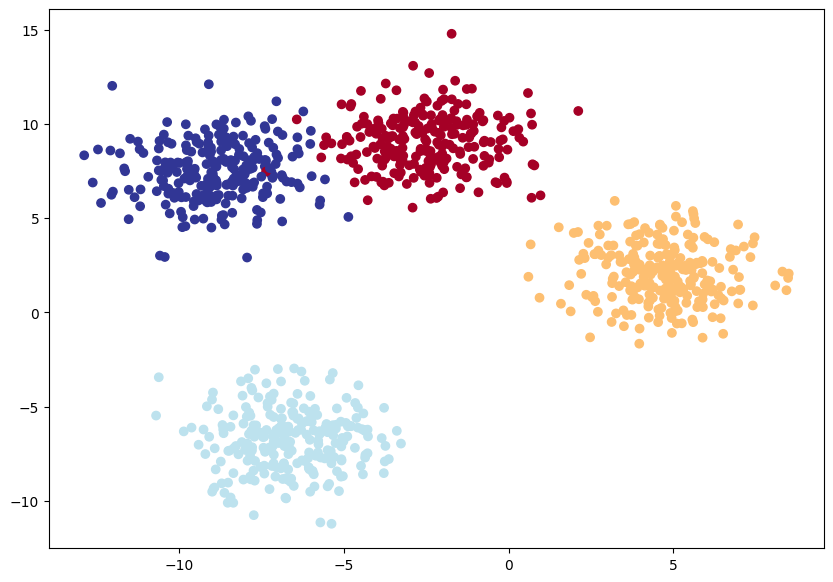

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob[:5], y_blob[:5])


# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torch import nn

# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        # nn.ReLU(), # inserire e togliere la strati non lineari per vedere la differenza
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        # nn.ReLU(), # inserire e togliere la strati non lineari per vedere la differenza
        nn.Linear(in_features = hidden_units, out_features = output_features), # how many classes are there?

)

  def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# creare loss e optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [5]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.0529, -0.0365, -1.7898,  0.7944],
        [ 0.9683, -0.1323, -0.9733,  2.0467],
        [-1.1028, -0.2093,  2.1335, -2.6274],
        [-0.6131, -0.1772,  1.1638, -1.4350],
        [ 0.7104, -0.1417, -0.5906,  1.4661]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [6]:
# logits -> prediction probabilities -> prediction labels
# make prediction logits
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2018, -0.0410, -1.8433,  1.0673],
        [ 0.7774, -0.2005,  0.3423,  1.2334],
        [-1.0137, -0.1808,  1.5757, -2.2689],
        [-0.1691, -0.0539, -1.3023,  0.2359],
        [ 0.9872, -0.1009, -1.5197,  2.2818]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2331, 0.1829, 0.0302, 0.5539],
        [0.2777, 0.1044, 0.1797, 0.4381],
        [0.0591, 0.1360, 0.7880, 0.0169],
        [0.2536, 0.2846, 0.0817, 0.3802],
        [0.1973, 0.0665, 0.0161, 0.7201]], device='cuda:0',
       grad_fn=<SliceBackward0>)


After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [7]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().

In [8]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2331, 0.1829, 0.0302, 0.5539], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

### Creating a training and testing loop for a multi-class PyTorch model
The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for epochs=100 and evaluate it every 10 epochs.

In [11]:
epochs = 100
torch.manual_seed(42)

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train) # il modello crea dei logits
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # print(y_logits.shape)
  # print(y_blob_train.shape)

  # 2. Loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)

  # 3. optimizer zero_grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_pred)


  if epoch % 10 == 0:
          print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.99513, Accuracy: 49.00% | Test Loss: 0.69894, Test Accuracy: 55.00%
Epoch: 10 | Loss: 0.16766, Accuracy: 99.12% | Test Loss: 0.15247, Test Accuracy: 99.50%
Epoch: 20 | Loss: 0.08971, Accuracy: 99.12% | Test Loss: 0.08134, Test Accuracy: 99.50%
Epoch: 30 | Loss: 0.06396, Accuracy: 99.12% | Test Loss: 0.05625, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.05174, Accuracy: 99.12% | Test Loss: 0.04394, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.04477, Accuracy: 99.25% | Test Loss: 0.03676, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.04032, Accuracy: 99.25% | Test Loss: 0.03211, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.03727, Accuracy: 99.25% | Test Loss: 0.02887, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03506, Accuracy: 99.25% | Test Loss: 0.02648, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03340, Accuracy: 99.25% | Test Loss: 0.02466, Test Accuracy: 99.50%


In [12]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.7587,   9.8521, -13.3678,  -8.7373],
        [  4.7543,  -9.1380,   2.7222,  10.3451],
        [ -8.9313, -11.9212,  18.2235,   9.8535],
        [  1.4377,   7.0764,  -7.8269,  -6.7459],
        [  9.2858,   4.4156, -13.1106,  -2.1863],
        [  5.3737, -11.5344,   4.1572,  12.9021],
        [ -9.3037,  -9.2923,  16.3544,   7.1221],
        [  7.8453,   0.8040,  -8.6679,   1.0969],
        [ -9.1408, -16.4029,  22.2209,  14.3068],
        [  8.2102,   2.1037, -10.1192,  -0.1215]], device='cuda:0')

In [13]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


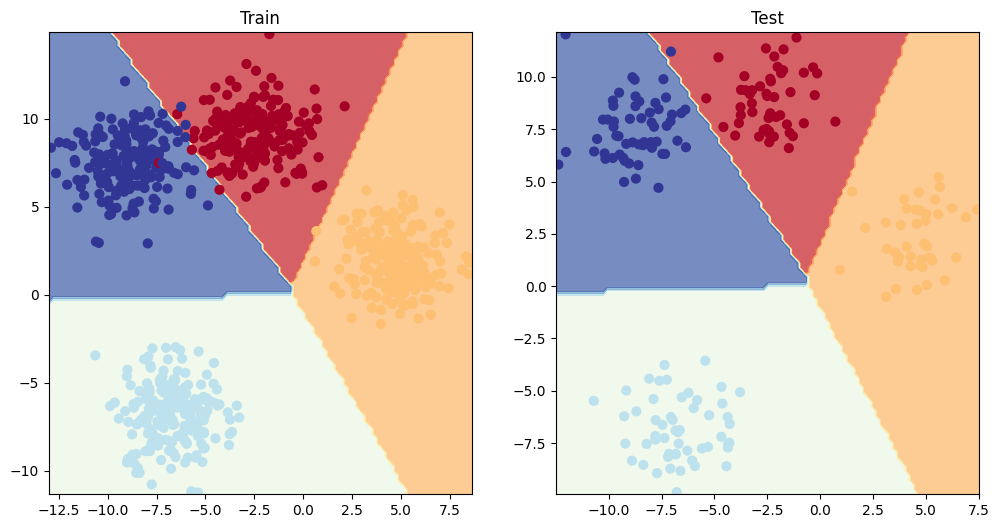

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)